### ERDDAP 2018 Oculus Glider QuickLooks and Analysis

#### Puget Sound Spring Test for SG404 - Test #2

Glider Data is subsetted into various components to be hosted on ERDDAP due to mulitple time dimensions

Tested with Python >= 3.6

In [4]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime
import xarray
import cmocean
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [5]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='sg404'))

The dataset is spread across multiple datasets in the erddap server so we will need to join them all together

In [6]:
sg404 = df['Dataset ID'].values
print(sg404)

['sg404_BF_Summer18' 'sg404_BF_Summer18_aanderaa'
 'sg404_BF_Summer18_wetlabs']


In [7]:
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is not None) for sg in sg404]
print(variables)
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is None) for sg in sg404]
print(variables)

[['temperature', 'pressure', 'time', 'longitude', 'salinity', 'density', 'latitude', 'ctd_depth'], ['aa4330_temp', 'time', 'aa4330_airsat', 'aanderaa4330_dissolved_oxygen'], ['time', 'wlbb2fl_temp']]
[['NC_GLOBAL', 'profileid'], ['NC_GLOBAL', 'profileid_aand'], ['wlbb2fl_sig695nm_adjusted', 'NC_GLOBAL', 'wlbb2fl_sig470nm_adjusted', 'profileid_wetlabs', 'wlbb2fl_sig700nm_adjusted']]


In [8]:
constraints = {
    'time>=': '2018-07-18T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = {'sg404_BF_Summer18':['profileid',
             'latitude', 
             'ctd_depth', 
             'longitude', 
             'salinity',
             'density', 
             'time', 
             'temperature'],
             'sg404_BF_Summer18_wetlabs':['time',
             'wlbb2fl_sig695nm_adjusted',
             'wlbb2fl_sig470nm_adjusted', 
             'wlbb2fl_sig700nm_adjusted', 
             'wlbb2fl_temp',
             'profileid_wetlabs'],
             'sg404_BF_Summer18_aanderaa':['time',
             'aanderaa4330_dissolved_oxygen',
             'aa4330_airsat',
             'aa4330_temp']}



In [9]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv'
          )
d.dataset_id='sg404_BF_Summer18'
d.variables=variables['sg404_BF_Summer18']
d.constraints=constraints

download_url = d.get_download_url()

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

def plot_params(df, var=None,varstr='',cmap=cmocean.cm.thermal,vmin=None,vmax=None):
    fig, ax = plt.subplots(figsize=(17, 2))
    if vmin:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap,vmin=vmin,vmax=vmax)
    else:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap)
        
    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b\n%H:%M')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel(varstr)
    ax.set_ylabel('Depth (m)')


In [11]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in sg404:
        print(row['Dataset ID'])
  
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            e.variables=variables[row['Dataset ID']]
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})    

sg404_BF_Summer18
sg404_BF_Summer18_aanderaa
sg404_BF_Summer18_wetlabs


In [12]:
try:
    e = ERDDAP(server=server_url,
        protocol='tabledap',
        response='csv',
    )
    e.dataset_id='sg404_BF_Summer18'
    e.variables=['profileid']
except HTTPError:
    print('Failed to generate url {}'.format(row['Dataset ID']))
dfp = e.to_pandas(
            skiprows=(1,)  # units information can be dropped.
            )

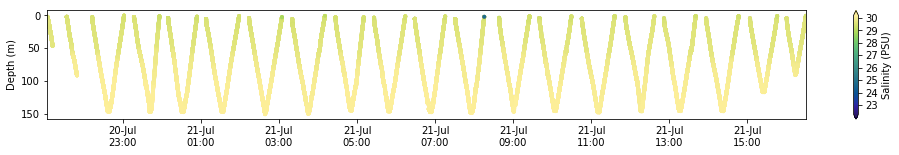

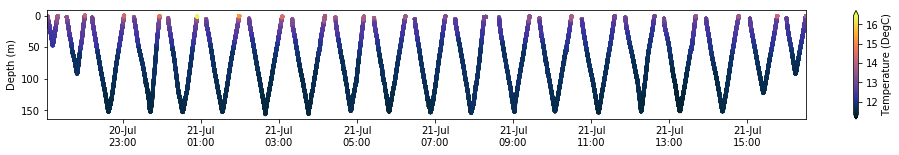

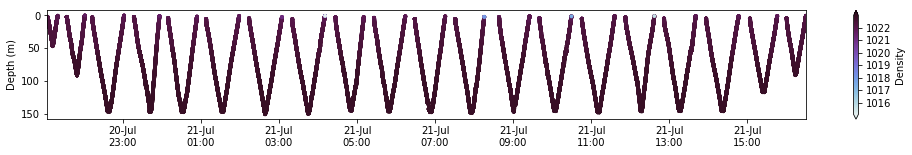

In [13]:
plot_params(dfs['sg404_BF_Summer18'], 'salinity','Salinity (PSU)',cmocean.cm.haline)

plot_params(dfs['sg404_BF_Summer18'], 'temperature','Temperature (DegC)')

plot_params(dfs['sg404_BF_Summer18'], 'density','Density',cmocean.cm.dense)

In [14]:
### depth needs to be downsampled to the other database freqencyies to plot chlor/oxy

dfwet = dfs['sg404_BF_Summer18_wetlabs'].join(dfs['sg404_BF_Summer18'])
dfaan = dfs['sg404_BF_Summer18_aanderaa'].join(dfs['sg404_BF_Summer18'])

#quick QC
dfaan.aa4330_airsat[dfaan.aa4330_airsat < 0] =np.nan


/Volumes/WDC_internal/Users/bell/anaconda2/envs/oculus-dash/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



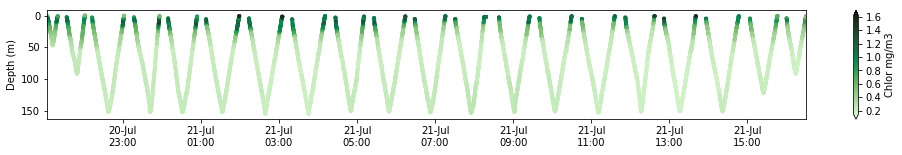

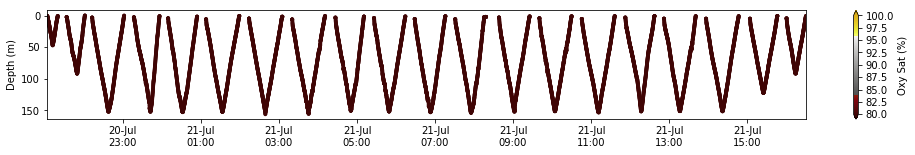

In [15]:
plot_params(dfwet, 'wlbb2fl_sig695nm_adjusted','Chlor mg/m3',cmocean.cm.algae)

plot_params(dfaan, 'aa4330_airsat','Oxy Sat (%)',cmocean.cm.oxy,vmin=80,vmax=100)

#### waterfall plots

In [16]:
def plot_waterfall(dfg, var=None,varstr='',delta=1):
    fig, ax = plt.subplots(figsize=(8, 12))
    shift = 0
    for g in dfg.groups:
        df = dfg.get_group(g)
        cs = ax.plot(df[var]+shift, df['ctd_depth'])
        shift=shift+delta

        
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(varstr)


In [17]:
dfg = dfs['sg404_BF_Summer18'].groupby('profileid')
dfwg = dfwet.groupby('profileid')
dfag = dfaan.groupby('profileid')


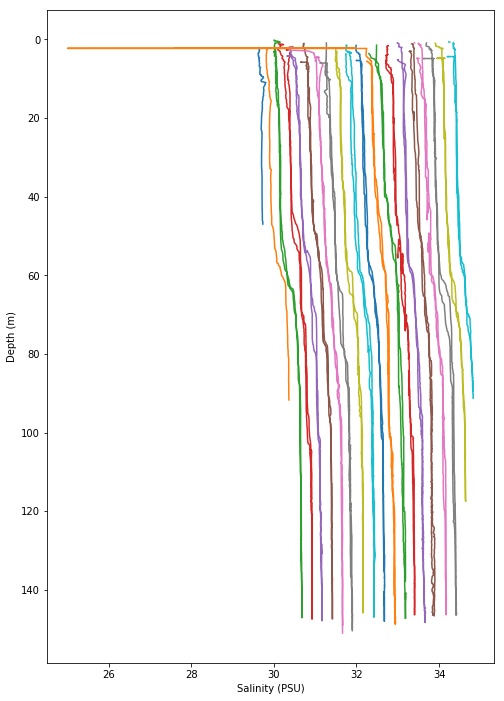

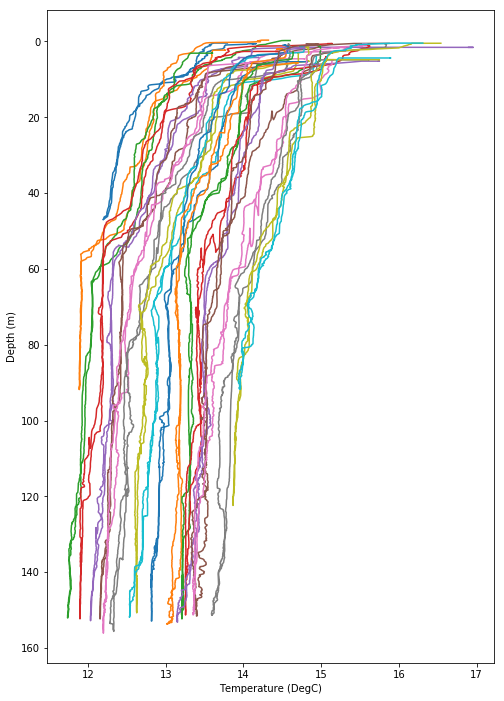

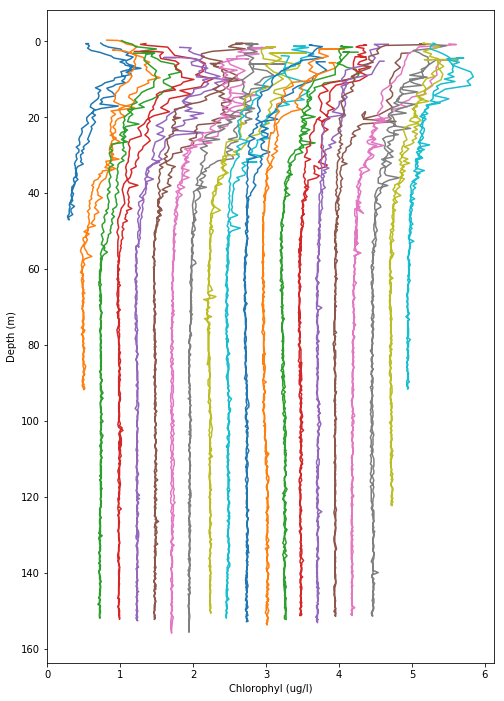

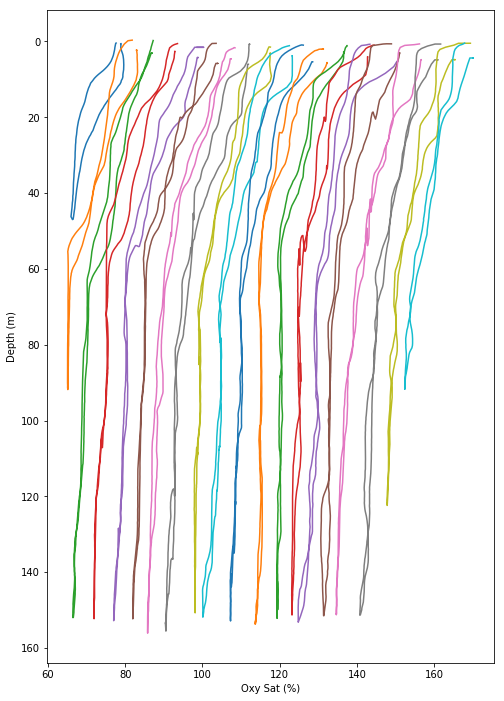

In [18]:
plot_waterfall(dfg, 'salinity','Salinity (PSU)',.25)
plot_waterfall(dfg, 'temperature','Temperature (DegC)',.125)
plot_waterfall(dfwg, 'wlbb2fl_sig695nm_adjusted','Chlorophyl (ug/l)',.25)
plot_waterfall(dfag, 'aa4330_airsat','Oxy Sat (%)',5)

## Plotly Test

In [19]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly
plotly.tools.set_credentials_file(username='shaun.bell', api_key='Iy4hhKvFuwXaSMm78Xjl')


In [20]:
def cmocean_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

thermal = cmocean_to_plotly(cmocean.cm.thermal, 1000)
algae = cmocean_to_plotly(cmocean.cm.algae, 1000)

In [21]:
def plot_waterfall(dfg, var=None,varstr='',delta=1):
    shift = 0
    dataPanda = []
    for g in list(dfg.groups.keys())[:]:
        df = dfg.get_group(g)

        trace = go.Scatter(
                    x = df[var]+shift,
                    y = df['ctd_depth'],
                    mode = 'line',
                    name = g
                ) 
        dataPanda.append(trace)
        
        shift = shift + delta
    layout =  go.Layout(
    xaxis={'title': varstr},
    yaxis={'title': 'Depth', 'autorange': 'reversed'}
    )
        

    fig1 = go.Figure(data=dataPanda, layout=layout)

        
    return fig1


In [22]:
py.iplot(plot_waterfall(dfg, 'salinity','Salinity (PSU)',.25), filename='waterfall-sal-404')


The draw time for this plot will be slow for clients without much RAM.


/Volumes/WDC_internal/Users/bell/anaconda2/envs/oculus-dash/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [23]:
py.iplot(plot_waterfall(dfg, 'temperature','Temperature (DegC)',.125), filename='waterfall-temp-404')


The draw time for this plot will be slow for clients without much RAM.


/Volumes/WDC_internal/Users/bell/anaconda2/envs/oculus-dash/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [24]:
py.iplot(plot_waterfall(dfwg, 'wlbb2fl_sig695nm_adjusted','Chlorophyl (ug/l)',.25), filename='waterfall-chlor-404')

Todo:   
- transfer plotly waterfall plots to a dash utility and allow a divenumber to be chosen with a +/- 10 plt window around it plotted
- cleanup and annotate this page
- put links to dash routines running on pavlof 